In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
# load the train data and labels 
# for detailed info about how the data is generated, see the "Data_Transformation_Demo" notebook
# these two files are generated from the whole EGMD dataset and are too big to store in Github.

X = np.load('egmd_mspc.npy')
y = np.load('egmd_label.npy')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=697)

print('Train-test split Done.')

Train-test split Done.


In [3]:
# Initialize a Keras CNN network

model = Sequential()  

model.add(Conv2D(32, (3,3), 1, input_shape = (X.shape[1],X.shape[2],1),  activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), 1, activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))

# Since we're doing a multi-label classification task, activation function set as sigmoid for the output layer

model.add(Dense(6, activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 18, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 9, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 9, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 4, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 2, 64)         36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 1, 64)        0

In [4]:
# add callback setting to model fitting process, to prevent overfitting

callback = [
    keras.callbacks.EarlyStopping(patience=5, monitor = 'val_accuracy'),
]

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
           epochs=25, 
           batch_size=200,
           callbacks=callback
           )

Epoch 1/25
15353/15353 [==============================] - 59s 4ms/step - loss: 0.2202 - accuracy: 0.7403 - val_loss: 0.1531 - val_accuracy: 0.8177
Epoch 2/25
15353/15353 [==============================] - 56s 4ms/step - loss: 0.1556 - accuracy: 0.8215 - val_loss: 0.1394 - val_accuracy: 0.8328
Epoch 3/25
15353/15353 [==============================] - 56s 4ms/step - loss: 0.1442 - accuracy: 0.8337 - val_loss: 0.1334 - val_accuracy: 0.8322
Epoch 4/25
15353/15353 [==============================] - 56s 4ms/step - loss: 0.1377 - accuracy: 0.8410 - val_loss: 0.1237 - val_accuracy: 0.8516
Epoch 5/25
15353/15353 [==============================] - 57s 4ms/step - loss: 0.1328 - accuracy: 0.8451 - val_loss: 0.1211 - val_accuracy: 0.8515
Epoch 6/25
15353/15353 [==============================] - 55s 4ms/step - loss: 0.1296 - accuracy: 0.8498 - val_loss: 0.1186 - val_accuracy: 0.8507
Epoch 7/25
15353/15353 [==============================] - 56s 4ms/step - loss: 0.1265 - accuracy: 0.8541 - val_loss: 0

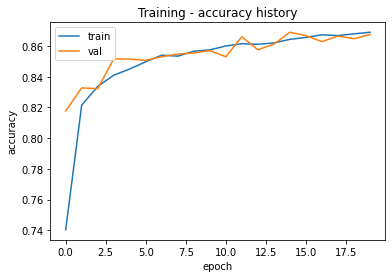

In [5]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training - accuracy history')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

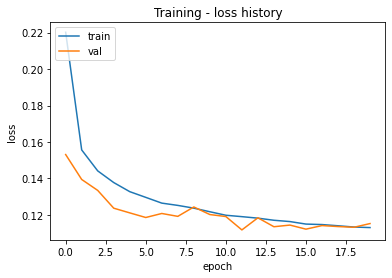

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training - loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
# Network evaluation

drum_hits = ['SD','HH','KD','RC','TT','CC']

result = []
pred_raw = model.predict(x_test)
pred = np.round(pred_raw)

for i in range(pred_raw.shape[0]):
  prediction = pred[i]
  if sum(prediction) == 0:
    raw = pred_raw[i]
    new = np.zeros(6)
    ind = raw.argmax()
    new[ind] = 1
    result.append(new)
  else:
    result.append(prediction)

print(classification_report(y_test, np.array(result), target_names=drum_hits))

              precision    recall  f1-score   support

          SD       0.91      0.92      0.92    130068
          HH       0.88      0.87      0.87    126300
          KD       0.88      0.92      0.90     81756
          RC       0.88      0.80      0.84     47364
          TT       0.91      0.91      0.91     30556
          CC       0.77      0.73      0.75      3952

   micro avg       0.89      0.89      0.89    419996
   macro avg       0.87      0.86      0.86    419996
weighted avg       0.89      0.89      0.89    419996
 samples avg       0.91      0.90      0.90    419996



In [ ]:
# Finish.